# Bootcamp Project - Product Recommendation

Our customer is a multi-national company that works on the health sector. They want to predict what products their
customers shall need the most, based on their past purchases but also on other variables that could be interesting
(this would be part of your research).

**Goal:** Build a recommendation engine to recommend relevant items to a user, based on historical data.

<a id='toc'></a>

### Table of Contents
1. [RFM evaluation](#rfm) <br>
    1. [Dataset overview](#dataset_overview) <br>
    2. [User defined functions](#user_functions) <br>
    3. [Dataset exploration](#data_exploration) <br>
    4. [Outliers](#outliers) <br>
    5. [Feature distributions](#features_distribution) <br>
    6. [K-Means](#k_means) <br>
        1. [Normalization](#normaliation) <br>
        2. [Determining the number of clusters](#number_of_clusters) <br>
        3. [Clustering with k = 2 and k = 3](#clusters) <br>

<a name='rfm'></a>

## 3. RFM evaluation
In this notebook we performed a RFM evaluation of the company clients. We made various assumptions that are enumerated
next:
* We just have the month and year of the sales and for that reason we have to define recency as the number of months
instead of the more normal number of days.
* We considered that we are currently in August 2019 and that the minimum recency is 1 for clients with purchases on
July 2019 (maximum date on the dataset)
* Used metrics:
    1. Recency: difference in months between the last purhcase and August 2019
    2. Frequency: total number of purchases
    3. Monetary: difference between sales and sales cost
* We removed 4 outliers that presented monetary values equal or below 0
* All the variables are strongly right skewed and for that reason we applied the box-cox transformation for all of them.
* We applied K-means with k=2 (optimal according to the optimization criteria) and k = 3

<a name='rfm'></a>

### 3.1. Import required modules


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

sns.set_style('darkgrid')
sns.set_palette(palette="RdBu")
sns.set(font_scale = 1.3, font = 'Segoe UI')

%matplotlib inline

<a name='user_functions'></a>

### 3.2. User defined functions

In [ ]:
RAW_DATA_DIR = '../../data/raw_datasets/'
INT_DATA_DIR = '02. IntermediateData'

df_pm = pd.read_csv(join(RAW_DATA_DIR, 'product_master.csv'))
df_stock = pd.read_csv(join(RAW_DATA_DIR, 'stock.csv'), dtype = str)


# Function 1: recursive function for finding a character (or, generally, a substring) in its nth occurrence in a string
def find_character_n(character, string, n):
    if n == 1:
        return string.find(character)
    else:
        return string.find(character, find_character_n(character, string, n-1) + 1)

    
def data_cleaning(df_pm = df_pm, df_stock = df_stock):
    
    # 1. PRODUCT MASTER ----------------------------------------------------------------------------------------------------------------
    # 1.1. Retrieving the id from the whole string 
    for column in df_pm.columns:
        df_pm[column] = df_pm[column].map(lambda x: x[find_character_n('_', x, x.count('_')) + 1:])

    # 1.2. Renaming the columns for clarity
    df_pm = df_pm.rename(columns = {'bravo_ww_fran_name': 'Company_GlobalGroup',
                                    'bravo_fran_name': 'Company_RegionalGroup',
                                    'bravo_sub_fran_name': 'Company_Area',
                                    'bravo_major_name': 'Product_Category',
                                    'bravo_minor_name': 'Product_Subcategory',
                                    'product_code': 'Product_ID'})

    # 2. STOCK -------------------------------------------------------------------------------------------------------------------------
    # 2.1. Retrieving the id from the whole string
    for column in df_stock.columns[:3]:
        df_stock[column] = df_stock[column].map(lambda x: x[find_character_n('_', x, x.count('_')) + 1:])

    # 2.2. Splitting month_code into two separate columns
    df_stock['month_code'] = df_stock['month_code'].map(lambda x: np.nan if x == 190001 else x)
    df_stock['Sale_Month'] = df_stock['month_code'].map(lambda x: np.nan if isinstance(x, float) and np.isnan(x) else x[-4:-2])
    df_stock['Sale_Year'] = df_stock['month_code'].map(lambda x: np.nan if isinstance(x, float) and np.isnan(x) else x[:4])

    # 2.3. Renaming the columns for clarity
    df_stock.rename(columns = {'country_code': 'Sale_Country',
                               'cac': 'Customer_ID',
                               'product_code': 'Product_ID',
                               'invoiced_sales': 'Sales',
                               'volume_primary_units': 'UnitsSold',
                               'inventory_cost': 'Sales_Cost'}, inplace = True)

    # 2.4. Converting sales parameters to floats 
    for column in ['Sales', 'UnitsSold', 'Sales_Cost']:
        df_stock[column] = df_stock[column].map(lambda x: np.nan if isinstance(x, float) and np.isnan(x) else x.replace(',', '.')).astype(float)

    # 2.5. Special cases
    # 2.5.1. “inventory_cost”, “volume_primary_units” and “invoiced_sales” as zero: no information available yet about the orders
    #        "Estes registos podem ser eliminados. São parte de off invoice adjustments registados em métricas que não foram partilhadas."
    mask_info_about_order_yet = (df_stock['Sales'] == 0) & (df_stock['UnitsSold'] == 0) & (df_stock['Sales_Cost'] == 0)
    mask_nan_sales = df_stock['Sales'].isnull()
    df_stock['InfoAboutOrderYet'] = np.where(~mask_info_about_order_yet, 1, np.where(mask_nan_sales, np.nan, 0))

    df_stock = df_stock.loc[df_stock['InfoAboutOrderYet'] != 0] \
                       .drop(columns = ['InfoAboutOrderYet'])

    # 2.5.2. Quando invoiced_sales é negativo e volume_primary_units a positivo: Acordo comercial com o cliente para compensação por atraso / ruptura de stock
    mask_is_compensation = (df_stock['Sales'] < 0) & (df_stock['UnitsSold'] > 0) 
    df_stock['IsCompensation'] = np.where(mask_is_compensation, 1, 0)

    # 2.5.3. Quando invoiced_sales é negativo e volume_primary_units a negativo: Devoluções de artigos e respectivo crédito
    mask_is_devolution = (df_stock['Sales'] < 0) & (df_stock['UnitsSold'] < 0) 
    df_stock['IsDevolution'] = np.where(mask_is_devolution, 1, 0)

    # 2.5.4. Quando invoiced_sales é negativo e volume_primary_units igual a 0: Créditos com movimento financeiro apenas
    mask_is_just_credit = (df_stock['Sales'] < 0) & (df_stock['UnitsSold'] == 0) 
    df_stock['IsJustCredit'] = np.where(mask_is_just_credit, 1, 0)

    # 2.6. Handling dates: Dates referred as "1900" are open orders, i.e., there is no date yet
    mask_open_order = (df_stock['Sale_Month'] == '01') & (df_stock['Sale_Year'] == '1900')
    mask_nan_order = (df_stock['Sale_Month'].isnull()) & (df_stock['Sale_Year'].isnull())

    df_stock['IsOrderClosed'] = np.where(~mask_open_order, 1, np.where(mask_nan_order, np.nan, 0)).astype(int)
    df_stock['Sale_Month'] = np.where(mask_open_order, np.nan, df_stock['Sale_Month'])
    df_stock['Sale_Year'] = np.where(mask_open_order, np.nan, df_stock['Sale_Year'])

    df_stock['Sale_YearMonth'] = pd.to_datetime(df_stock['Sale_Month'] + df_stock['Sale_Year'], format = '%m%Y')
    
    df_stock = df_stock.loc[~df_stock['Sale_YearMonth'].isnull()]
    
    # 2.7. Dropping rows where both Sales, UnitsSold and Sales_Cost are NaN
    mask_no_sales_info = (df_stock['Sales'].isnull()) & (df_stock['UnitsSold'].isnull()) & (df_stock['Sales_Cost'].isnull())
    df_stock = df_stock.loc[~mask_no_sales_info] \
                       .reset_index(drop = True)

    # 3. MERGING -----------------------------------------------------------------------------------------------------------------------
    df = df_stock.merge(df_pm,
                        on = 'Product_ID',
                        how = 'left')
    
    # 3.1. Converting ID's to integers
    for column in ['Customer_ID', 'Product_ID', 'Product_Category', 'Product_Subcategory']:
        df[column] = df[column].map(lambda x: np.nan if isinstance(x, float) and np.isnan(x) else int(x))

    df = df[['Customer_ID', 'Product_ID', 'Product_Category', 'Product_Subcategory', 'Sales', 'UnitsSold', 'Sales_Cost',
             'Sale_Country', 'Company_GlobalGroup', 'Company_RegionalGroup', 'Company_Area',
             'Sale_Month', 'Sale_Year', 'Sale_YearMonth', 'IsOrderClosed', 'IsCompensation', 'IsDevolution', 'IsJustCredit']]
    
    return df


if __name__ == '__main__':
    
    df = data_cleaning()

<a name='data_exploration'></a>

### 3.3. Dataset exploration

In [2]:
df.head()

,Customer_ID,Product_ID,Product_Category,Product_Subcategory,Sales,UnitsSold,Sales_Cost,Sale_Country,Company_GlobalGroup,Company_RegionalGroup,Company_Area,Sale_Month,Sale_Year,Sale_YearMonth,IsOrderClosed,IsCompensation,IsDevolution,IsJustCredit
0,3,20,0.0,0.0,95.098599,4.0,24.409992,0,0,0,0,04,2018,2018-04-01,1,0,0,0
1,3,22,0.0,0.0,-773.621317,-1.0,-236.550000,0,0,0,0,02,2019,2019-02-01,1,0,1,0
2,3,23,0.0,0.0,375.423736,6.0,108.936137,0,0,0,0,12,2018,2018-12-01,1,0,0,0
3,3,24,0.0,0.0,9.396435,1.0,6.690796,0,0,0,0,04,2018,2018-04-01,1,0,0,0
4,3,25,0.0,0.0,169.491679,2.0,24.813898,0,0,0,0,07,2018,2018-07-01,1,0,0,0


In [3]:
df.iloc[0].T

Customer_ID                                3
Product_ID                                20
Product_Category                         0.0
Product_Subcategory                      0.0
Sales                              95.098599
UnitsSold                                4.0
Sales_Cost                         24.409992
Sale_Country                               0
Company_GlobalGroup                        0
Company_RegionalGroup                      0
Company_Area                               0
Sale_Month                                04
Sale_Year                               2018
Sale_YearMonth           2018-04-01 00:00:00
IsOrderClosed                              1
IsCompensation                             0
IsDevolution                               0
IsJustCredit                               0
Name: 0, dtype: object

In [4]:
len(df)

4538468

In [5]:
df['Customer_ID'].nunique()

8376

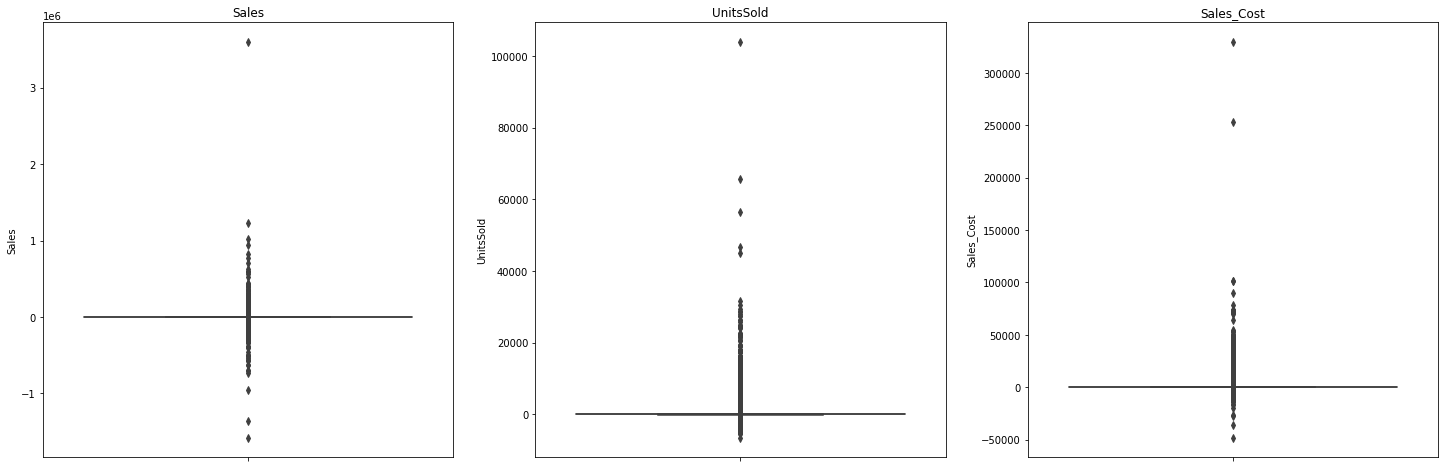

In [8]:
df_outliers = df[['Sales', 'UnitsSold', 'Sales_Cost']].rename({'Sales': 'Invoiced Sales',
                                                               'UnitsSold': 'Volume Primary Units',
                                                               'Sales_Cost': 'Inventory Cost'})

fig, axes = plt.subplots(ncols = len(df_outliers.columns),
                         figsize = (25, 8))

for i in range(len(df_outliers.columns)):
    sns.boxplot(y = df_outliers[df_outliers.columns[i]],
                data = df_outliers,
                ax = axes[i])
    
    axes[i].set_title(df_outliers.columns[i])

* We only have th month and year of sales, so we will ust consider the number of months has recency.

In [9]:
print('Min Date:', df['Sale_YearMonth'].min())
print('Max Date:', df['Sale_YearMonth'].max())

Min Date: 2018-01-01 00:00:00
Max Date: 2019-07-01 00:00:00


* We consider that we are currently at August 2019, so the minimum recency is 1, for the clients that purchases in
July 2019.

In [10]:
actual_date = pd.to_datetime('2019-08-01')

df_copy = df.copy()
df_copy['Profit'] = df_copy['Sales'] - df_copy['Sales_Cost']

df_rfm = df_copy[['Customer_ID', 'Sale_YearMonth', 'Profit']].groupby('Customer_ID').agg({'Sale_YearMonth': {np.max, 'count'}, 'Profit': np.sum})
df_rfm.columns = ['LastPurchase', 'NumberOfPurchases', 'MonetaryValue']

df_rfm['Recency'] = df_rfm['LastPurchase'].map(lambda x: (actual_date - x) / np.timedelta64(1, 'M')).astype(int)

df_rfm = df_rfm[['Recency', 'NumberOfPurchases', 'MonetaryValue']]
df_rfm

,Recency,NumberOfPurchases,MonetaryValue
Customer_ID,,,
0,1,143,15279.328367
3,1,826,133472.208385
4,1,926,436309.238771
5,1,2758,631314.185304
6,1,3886,905612.039386
...,...,...,...
10022,6,2,949.532513
10024,15,1,-862.086278
10025,11,2,458.622773


<a name='outliers'></a>

### 3.4. Outliers

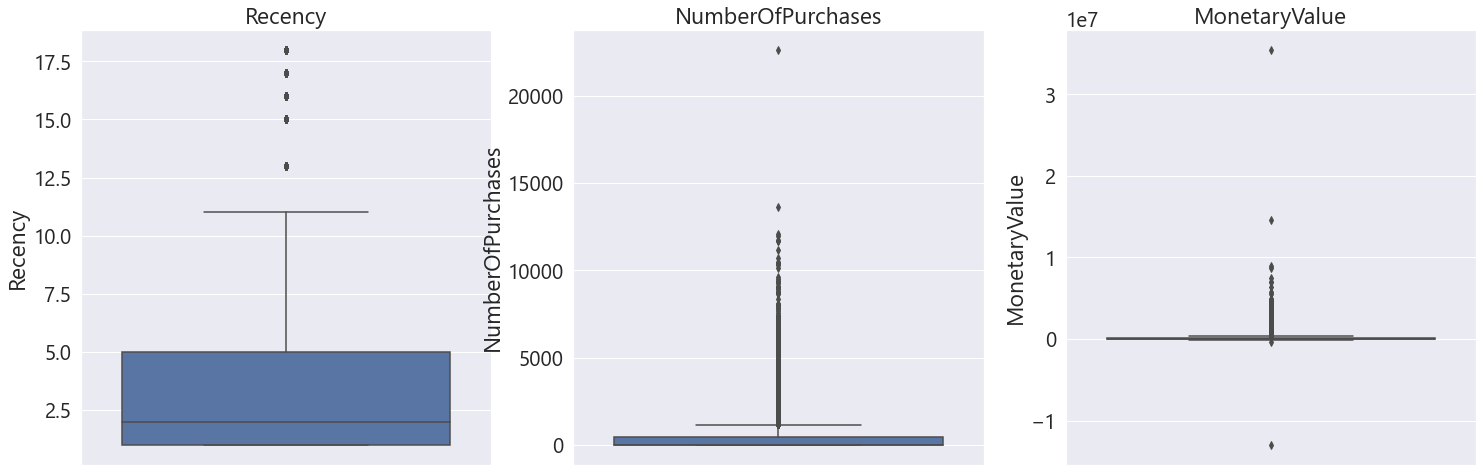

In [54]:
sns.set_style('whitegrid')
sns.set(font_scale = 1.9, font = 'Segoe UI')

fig, axes = plt.subplots(ncols = len(df_rfm.columns),
                         figsize = (25, 8))

for i in range(len(df_rfm.columns)):
    sns.boxplot(y = df_rfm[df_rfm.columns[i]],
                data = df_rfm,
                ax = axes[i])
    
    axes[i].set_title(df_rfm.columns[i])


plt.show()

fig.savefig('Outliers.png', dpi = 300, transparent = True)

In [11]:
# Removing some outliers from Number of Purchases and Monetary Value

# IQR Method will not work out with these extremely right-skewed distributions
Q1_NoP = df_rfm['NumberOfPurchases'].quantile(0.25)
Q3_NoP = df_rfm['NumberOfPurchases'].quantile(0.75)
IQR_NoP = Q3_NoP - Q1_NoP

print('Q1:', Q1_NoP, 'Q3:', Q3_NoP)

Q1: 4.0 Q3: 473.0


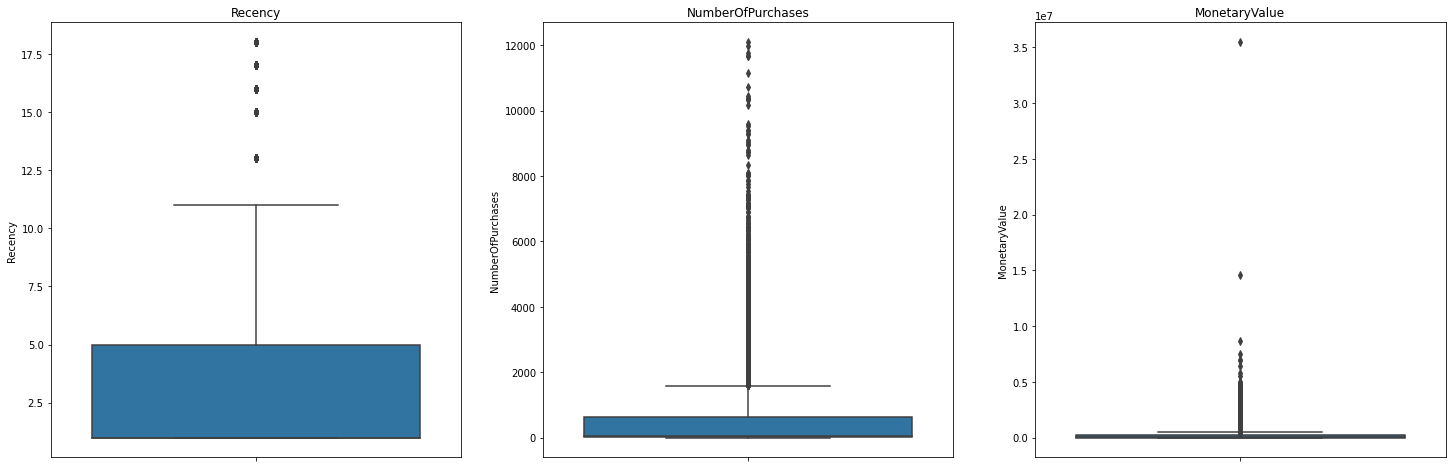

In [12]:
# Let's just remove the top two points from Number of Purchases and the top two points from Monetary Value plus the non-positive ones
df_rfm_copy = df_rfm.copy().reset_index()

NoP_ToRemove = df_rfm_copy.sort_values(by = 'NumberOfPurchases', ascending = False).index[[0, 1]].tolist()
MV_ToRemove_Top = df_rfm_copy.sort_values(by = 'MonetaryValue', ascending = False).index[[0, 1]].tolist()

Outliers_ToRemove = NoP_ToRemove
df_rfm2 = df_rfm_copy.drop(df_rfm_copy.index[Outliers_ToRemove]) \
                     .loc[df_rfm_copy['MonetaryValue'] > 0]

df_rfm2.set_index('Customer_ID', inplace = True)

# Plotting again
fig, axes = plt.subplots(ncols = len(df_rfm2.columns),
                         figsize = (25, 8))

for i in range(len(df_rfm2.columns)):
    sns.boxplot(y = df_rfm2[df_rfm2.columns[i]],
                data = df_rfm2,
                ax = axes[i])
    
    axes[i].set_title(df_rfm2.columns[i])

<a name='features_distribution'></a>

### 3.5. Feature distributions

In [13]:
len(df_rfm2)

7363

In [14]:
df_rfm2['Recency'].value_counts()

1     3882
2      765
5      651
3      377
4      280
13     222
7      203
17     168
6      146
8      130
9      106
10     100
16      91
15      89
11      77
18      76
Name: Recency, dtype: int64

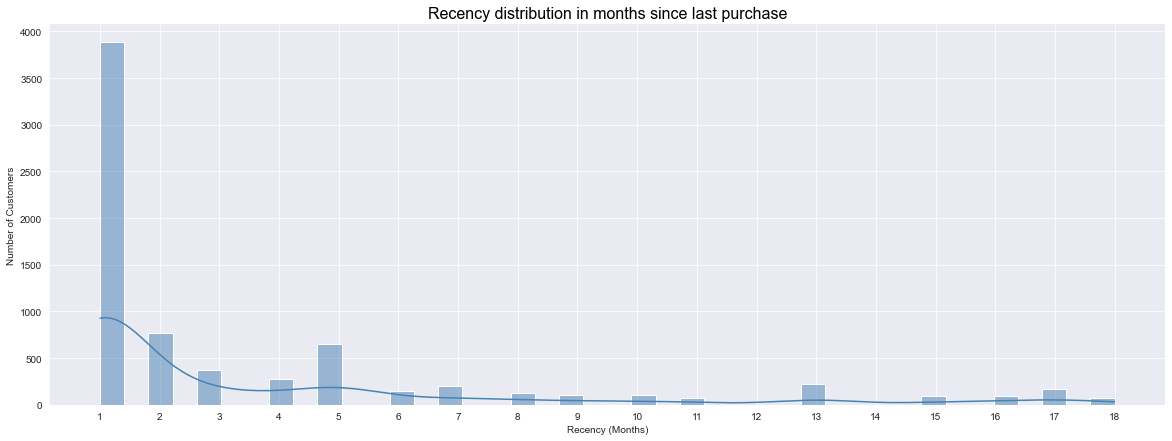

In [15]:
sns.set_style('darkgrid')

fig = plt.figure(figsize = (20, 7))

ax = sns.histplot(x = df_rfm2['Recency'],
                  data = df_rfm2,
                  color = "steelblue",
                  kde = True)


ax.set_xticks(range(1, 19))
ax.set_xlabel('Recency (Months)')
ax.set_ylabel('Number of Customers')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.title('Recency distribution in months since last purchase', fontsize= 16, color = 'black')
plt.show()

fig.savefig('Recency_Distribution.png', dpi = 300, transparent = True)

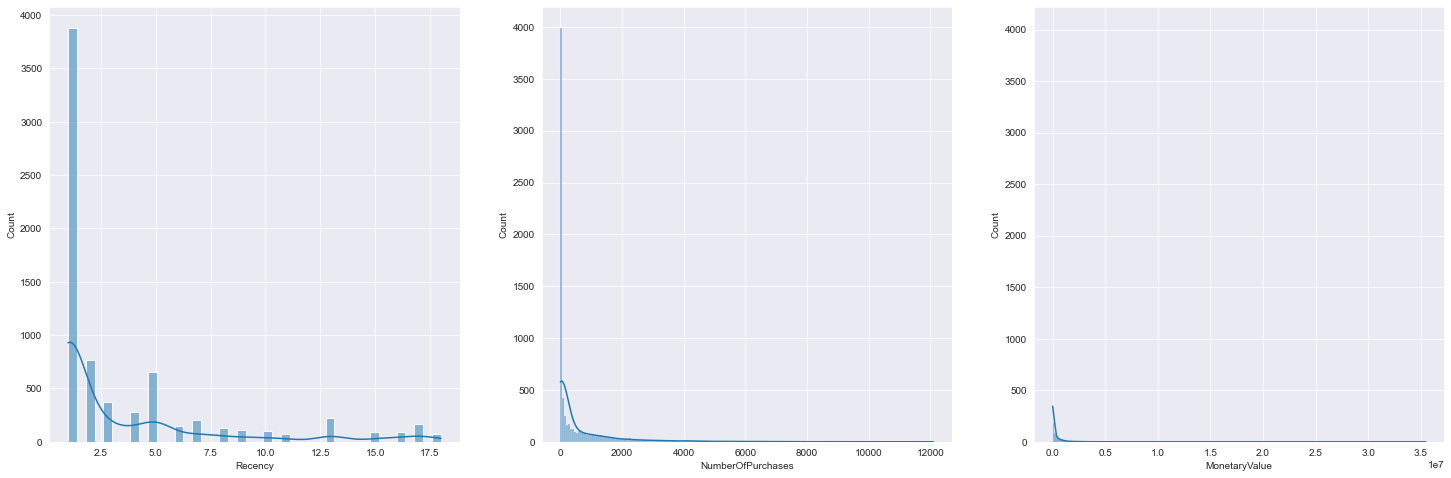

In [16]:
# Distribuições Originais
fig, axes = plt.subplots(ncols = len(df_rfm2.columns),
                         figsize = (25, 8))

for i in range(len(df_rfm2.columns)):
    sns.histplot(x = df_rfm2.columns[i],
                 data = df_rfm2,
                 kde = True,
                 ax = axes[i])

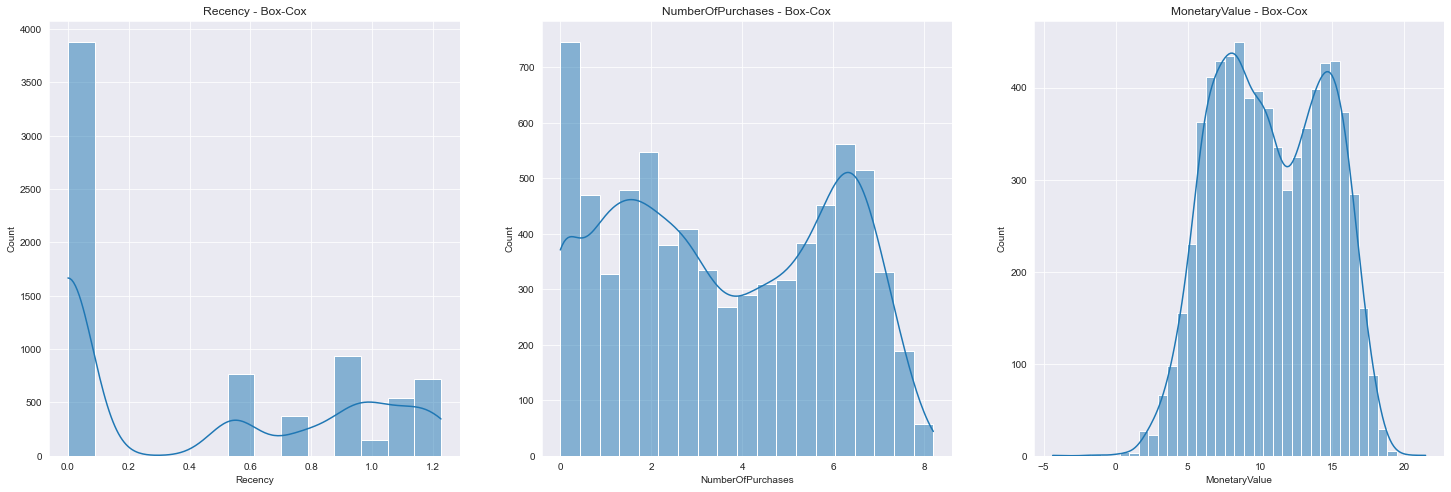

In [17]:
from scipy import stats

df_rfm2_boxcox = df_rfm2.copy()
df_rfm2_boxcox['Recency'] = df_rfm2_boxcox['Recency'].apply(lambda x: 1 if x == 0 else x)   

for column in df_rfm2.columns:
    
    fitted_data, fitted_lambda = stats.boxcox(df_rfm2_boxcox[column])
    df_rfm2_boxcox[column] = fitted_data
    
    
fig, axes = plt.subplots(ncols = len(df_rfm2.columns),
                         figsize = (25, 8))

for i in range(len(df_rfm2.columns)):
    
    sns.histplot(x = df_rfm2_boxcox.columns[i],
                 data = df_rfm2_boxcox,
                 kde = True,
                 ax = axes[i])
    
    axes[i].set_title(df_rfm2_boxcox.columns[i] + " - Box-Cox")

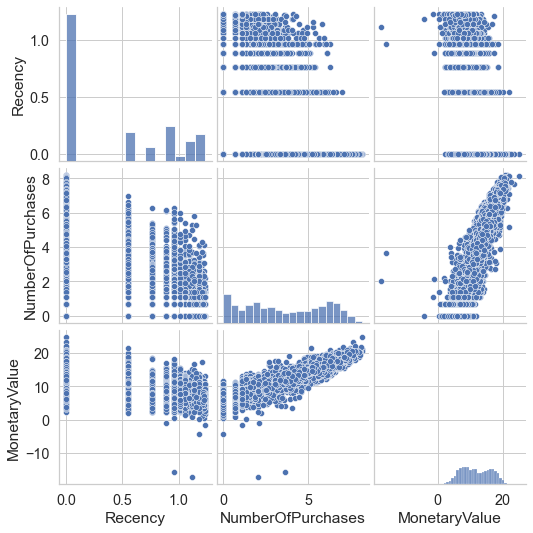

In [14]:
sns.pairplot(data = df_rfm2_boxcox)

<a name='k_means'></a>

### 3.6. K-Means

<a name='normaliation'></a>

#### 3.6.1. Normalization

In [19]:
# Normalize the variables - tenho de checkar se o MinMaxScaler é o melhor neste caso
scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df_rfm2_boxcox), columns = df_rfm2_boxcox.columns)
df_norm.head()

,Recency,NumberOfPurchases,MonetaryValue
0,0.0,0.562768,0.587236
1,0.0,0.742516,0.695185
2,0.0,0.753906,0.756550
3,0.0,0.860741,0.776043
4,0.0,0.893592,0.795245


<a name='number_of_clusters'></a>

#### 3.6.2. Determining the number of clusters

[(1.0, 10.0), Text(0.5, 1.0, 'Silhouette Method')]

findfont: Font family ['Segoe UI'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Segoe UI'] not found. Falling back to DejaVu Sans.


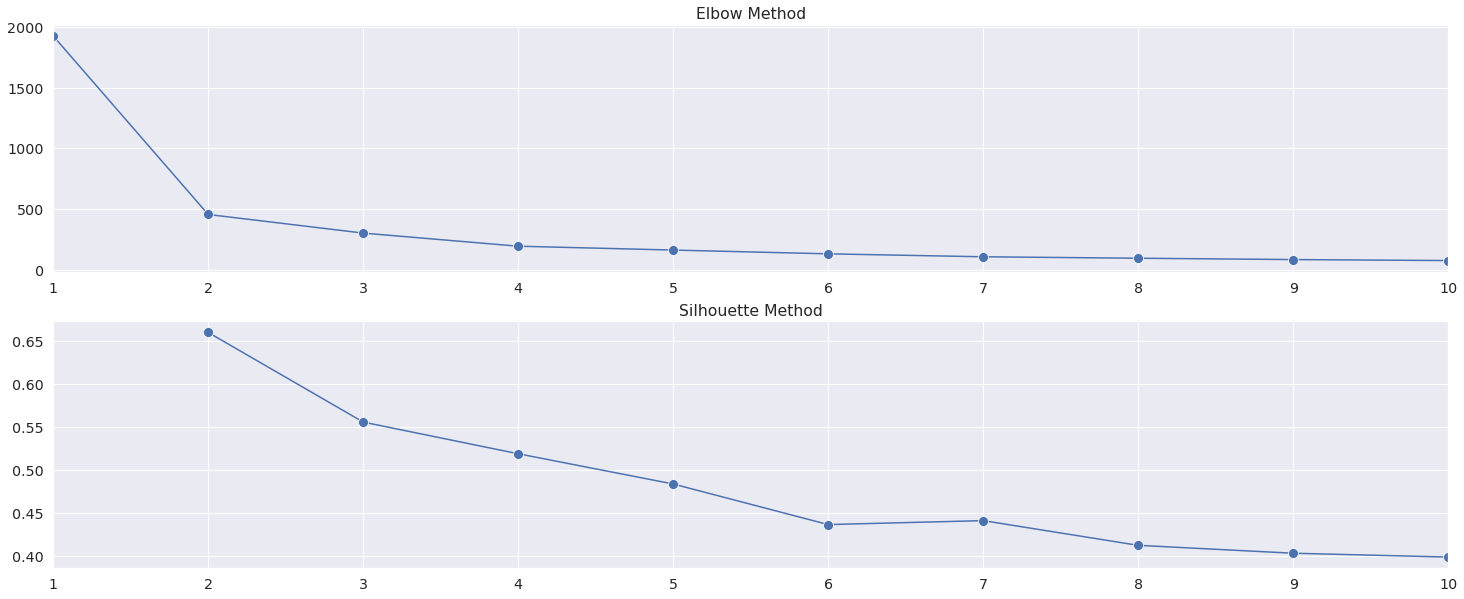

In [22]:
df_clust = df_norm.copy()

sse = list()
silhouette_k = list()
#random_state = 10

max_nr_clusters = 10
for k in range(1, max_nr_clusters + 1):
    
    # Elbow
    kmeans_k = KMeans(n_clusters = k, init = 'k-means++')
    kmeans_k.fit(df_clust)
    sse.append(kmeans_k.inertia_)

    # Silhouette
    cluster_labels = kmeans_k.fit_predict(df_clust)
    if k != 1:
        silhouette_k.append(silhouette_score(df_clust, cluster_labels))        

        
fig, axes = plt.subplots(nrows = 2,
                         figsize = (25, 10))

ep = sns.lineplot(x = range(1, max_nr_clusters + 1), y = sse, marker = 'o', ms = 10, ax = axes[0])
ep.set(xlim=(1, 10), title = "Elbow Method")

sp = sns.lineplot(x = range(2, max_nr_clusters + 1), y = silhouette_k, marker = 'o', ms = 10, ax = axes[1])
sp.set(xlim=(1, 10), title = "Silhouette Method")

Looks like 2 is optimal, 3 comes next

<a name='clusters'></a>

#### 3.6.3. Clustering with k = 2 and k = 3

In [23]:
clustering_2 = KMeans(n_clusters = 2, init = 'k-means++')
clustering_2.fit(df_norm)
df_norm["Cluster_k2"] = clustering_2.labels_

clustering_3 = KMeans(n_clusters = 3, init = 'k-means++')
clustering_3.fit(df_norm)
df_norm["Cluster_k3"] = clustering_3.labels_

df_norm.head(10)

,Recency,NumberOfPurchases,MonetaryValue,Cluster_k2,Cluster_k3
0,0.0,0.562768,0.587236,0,2
1,0.0,0.742516,0.695185,0,0
2,0.0,0.753906,0.756550,0,0
3,0.0,0.860741,0.776043,0,0
4,0.0,0.893592,0.795245,0,0
5,0.0,0.698114,0.796538,0,0
6,0.0,0.855831,0.803799,0,0
7,0.0,0.913328,0.779993,0,0
8,0.0,0.834200,0.801965,0,0
9,0.0,0.729608,0.794368,0,0


In [24]:
avg_k2 = df_norm.groupby('Cluster_k2', as_index = False).mean()[['Cluster_k2', 'Recency', 'NumberOfPurchases', 'MonetaryValue']]
avg_k2

,Cluster_k2,Recency,NumberOfPurchases,MonetaryValue
0,0,0.013531,0.648187,0.684095
1,1,0.754763,0.191958,0.466728


In [25]:
avg_k3 = df_norm.groupby('Cluster_k3', as_index = False).mean()[['Cluster_k3', 'Recency', 'NumberOfPurchases', 'MonetaryValue']]
avg_k3

,Cluster_k3,Recency,NumberOfPurchases,MonetaryValue
0,0,0.007636,0.763968,0.742892
1,1,0.754763,0.191958,0.466728
2,2,0.025901,0.405244,0.560722


<AxesSubplot:xlabel='variable', ylabel='value'>

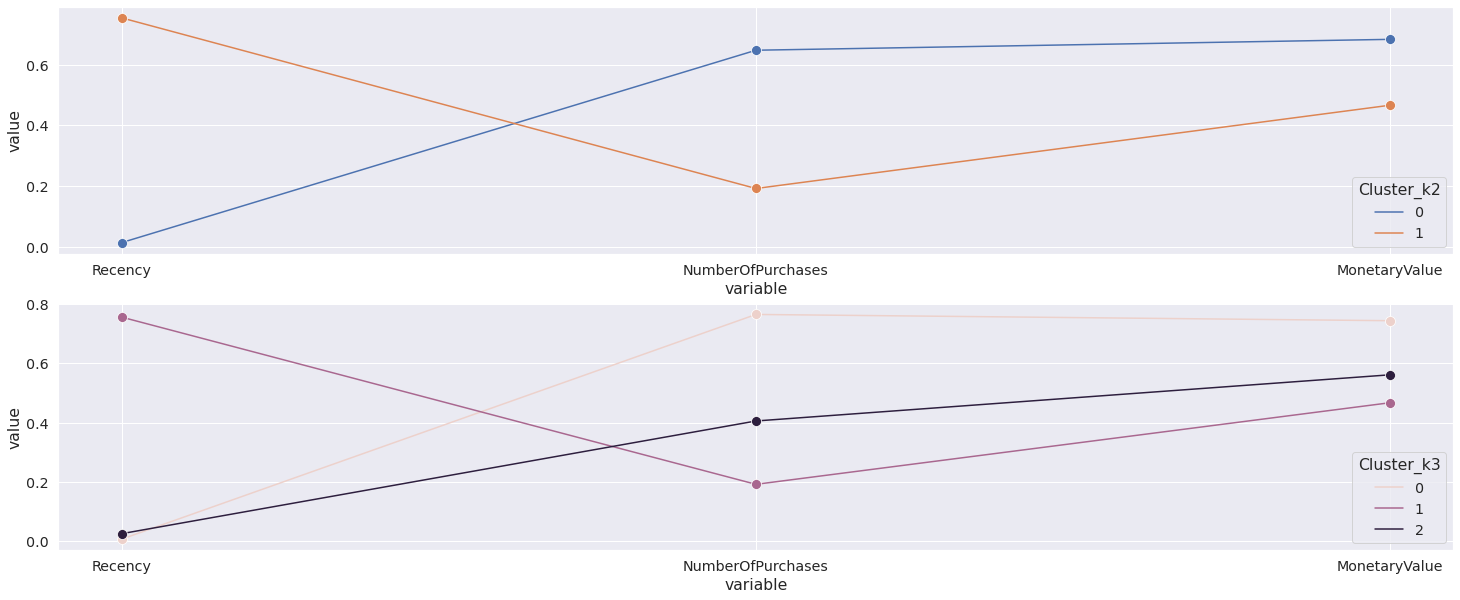

In [26]:
fig, axes = plt.subplots(nrows = 2,
                         figsize = (25, 10))

sns.lineplot(x = 'variable',
             y = 'value',
             hue = 'Cluster_k2',
             data = pd.melt(avg_k2, ['Cluster_k2']),
             marker = 'o',
             ms = 10,
             ax = axes[0])

sns.lineplot(x = 'variable',
             y = 'value',
             hue = 'Cluster_k3',
             data = pd.melt(avg_k3, ['Cluster_k3']),
             marker = 'o',
             ms = 10,
             ax = axes[1])

<AxesSubplot:xlabel='NumberOfPurchases', ylabel='MonetaryValue'>

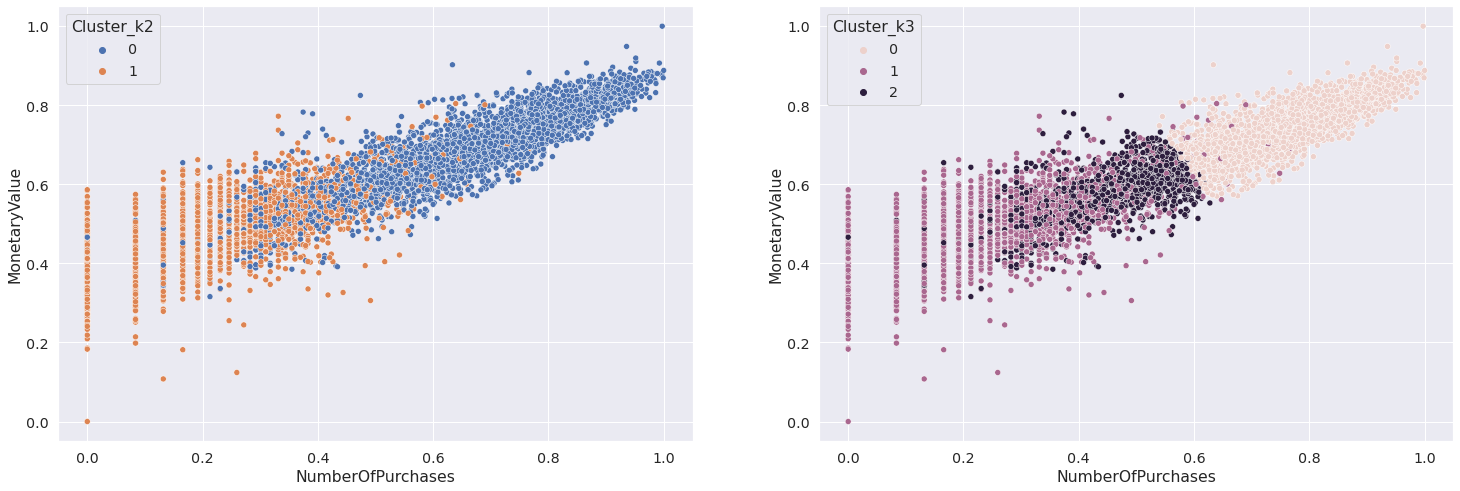

In [27]:
fig, axes = plt.subplots(ncols = 2,
                         figsize = (25, 8))

sns.scatterplot(x = 'NumberOfPurchases',
             y = 'MonetaryValue',
             hue = 'Cluster_k2',
             data = df_norm,
             marker = 'o',
             ax = axes[0])

sns.scatterplot(x = 'NumberOfPurchases',
             y = 'MonetaryValue',
             hue = 'Cluster_k3',
             data = df_norm,
             marker = 'o',
             ax = axes[1])

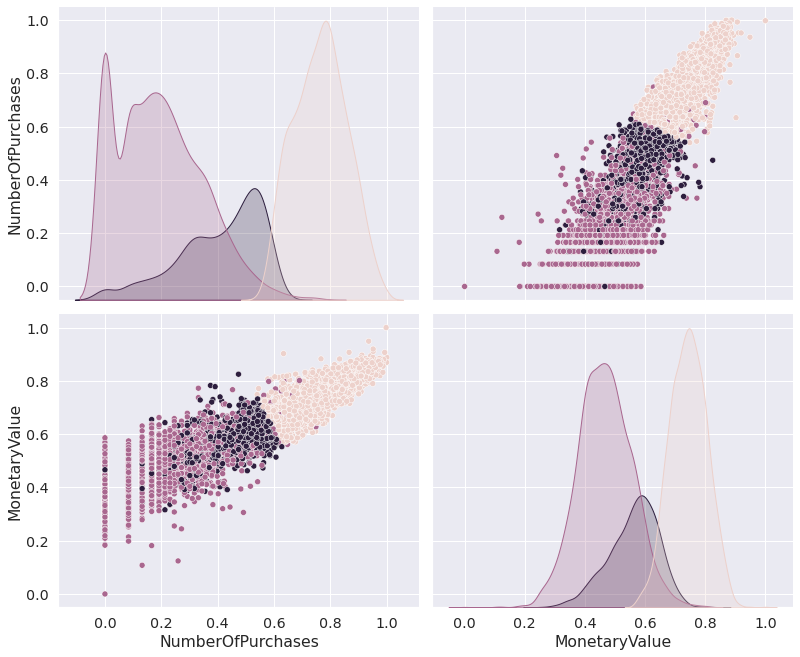

In [28]:
ax = sns.pairplot(data = df_norm[['NumberOfPurchases', 'MonetaryValue', 'Cluster_k3']],
                  hue = 'Cluster_k3')

ax.fig.set_size_inches(16, 10)
ax._legend.remove()
#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)

plt.show()

ax.savefig('Clusters_Pairplot.png', dpi = 300, transparent = True)